In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import re
from datetime import datetime


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# for i, t in enumerate(df['time']):
#   df['time'][i] = re.sub("<[^>]*>", '', str(t))
#   df['time'][i] = re.sub("'>", '', df['time'][i])

## AL JAZEERA

In [ ]:
filename2 = 'drive/My Drive/SML310/alj50.csv'
aldf = pd.read_csv(filename2)

In [ ]:
aldf.head()

,title,time,content
0,<h1>Israel court convicts seven over wedding v...,Published On 27 Apr 2022,An Israeli court convicted seven Jewish men of...
1,<h1>New Israeli rules on foreigners visiting W...,Published On 27 Apr 2022,"Palestinian legal experts, academics and digit..."
2,<h1>Palestinian killed during Israeli raid on ...,Published On 27 Apr 2022,Israeli forces have shot dead a Palestinian t...
3,<h1>Israeli forces kill Palestinian in occupie...,Published On 26 Apr 2022,Israeli forces have killed a Palestinian man d...
4,<h1>Egypt’s role in Gaza: More than a mediator...,Published On 26 Apr 2022,Tensions have once again escalated between Ha...


In [ ]:
aldf['title'][0]

'<h1>Israel court convicts seven over wedding video celebrating arson</h1>'

In [ ]:
## Removing the HTML tags

for i in range(len(aldf['title'])):
  aldf['title'][i] = re.sub("<[^>]*>", "", str(aldf['title'][i]))

In [ ]:
## Cleaning and converting the time

for i in range(len(aldf['time'])):
  aldf['time'][i] = re.sub("Published On ", "", str(aldf['time'][i]))

In [ ]:
aldf['time'][354]

'nan'

In [ ]:
month_to_num = {
    'Jan': '01',
    'Feb': '02',
    'Mar': '03',
    'Apr': '04',
    'May': '05',
    'Jun': '06',
    'Jul': '07',
    'Aug': '08',
    'Sep': '09',
    'Oct': '10',
    'Nov': '11',
    'Dec': '12'
}



for i in range(len(aldf['time'])):
  try:
    day, month, year = aldf['time'][i].split()
    month = month_to_num[month]
    date = datetime(year=int(year), month=int(month), day=int(day))
    aldf['time'][i] = date

  except:
    print(i)
    continue
  #datetime.fromtimestamp(aldf['time'][i])

81
354


In [ ]:
aldf.head()

,title,time,content
0,Israel court convicts seven over wedding video...,2022-04-27 00:00:00,An Israeli court convicted seven Jewish men of...
1,New Israeli rules on foreigners visiting West ...,2022-04-27 00:00:00,"Palestinian legal experts, academics and digit..."
2,Palestinian killed during Israeli raid on Jeni...,2022-04-27 00:00:00,Israeli forces have shot dead a Palestinian t...
3,Israeli forces kill Palestinian in occupied We...,2022-04-26 00:00:00,Israeli forces have killed a Palestinian man d...
4,Egypt’s role in Gaza: More than a mediator,2022-04-26 00:00:00,Tensions have once again escalated between Ha...


In [ ]:
aldf.dropna(subset=['title', 'content'], inplace=True)
aldf.reset_index(drop=True, inplace=True)

In [ ]:
docs_al = aldf['content'].copy(deep=True)
titles_al = aldf['title'].copy(deep=True)

In [ ]:
docs_al[0]

'An Israeli court convicted seven Jewish men of inciting violence and terror and a slew of other charges for their involvement in a 2015 wedding in which participants celebrated an arson attack that killed a Palestinian toddler and his parents.'

## TOKENIZE

In [ ]:
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Split the documents into tokens.

def tokenize(docs):
  tokenizer = RegexpTokenizer(r'\w+')
  for idx in range(len(docs)):
      docs[idx] = docs[idx].lower()  # Convert to lowercase.
      docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

  # Remove numbers, but not words that contain numbers.
  docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

  # Remove words that are only one character.
  docs = [[token for token in doc if len(token) > 1] for doc in docs]

  return docs

In [ ]:
# Delete stopwords
def remove_stop(docs):

  s=set(stopwords.words('english'))

  for i, doc in enumerate(docs):
    docs[i] = [x for x in docs[i] if x not in s]
  
  return docs

In [ ]:
# Remove the 50 most common words

from nltk.probability import FreqDist

def remove_N_common(docs, N):
  allWords = []

  for wordList in docs:
    for word in wordList:
      allWords.append(word)

  corpus_frequency = FreqDist(allWords)
  corpus_common=corpus_frequency.most_common(N)

  mclist = set()
  for i in range(len(corpus_common)):
      mclist.add(corpus_common[i][0])

  docs = [[token for token in doc if token not in mclist] for doc in docs]
  return docs



In [ ]:
# Remove words that appear in less than 5% of documents

def remove_N_least(docs, N):

  count = {}
  less = set()

  for i in range(len(docs)):
    for token in docs[i]:
      try:
        count[token].add(i)
      except:
        count[token] = {i}

  for i in count:
    count[i] = len(count[i]) / len(docs)
    if count[i] <= N:
      less.add(i)

  print(len(less))
  print(len(docs))

  return count, less

  #docs = [[token for token in doc if token not in count] for doc in docs]
  #return docs

    

  

In [ ]:
# Remove words that are not POS other than a noun, adjective or adverb
import nltk
nltk.download('averaged_perceptron_tagger')

import spacy
from spacy import displacy

NER = spacy.load("en_core_web_sm")

def keep_pos(docs):

  tagged_docs_al = []

  for tokens in docs:
    tagged = nltk.pos_tag(tokens)
    tagged_docs_al.append(tagged)

  # if it starts with N: Noun, Starts with RB: Adverb, starts with JJ: Adjective

  keep_pos = set()

  for tags in tagged_docs_al:
    for word, pos in tags:
      if pos.startswith('N'):
        keep_pos.add(word)
        
      elif pos.startswith('RB'):
        keep_pos.add(word)
        
      elif pos.startswith('JJ'):
        keep_pos.add(word)
        
      else:
        continue

  # Remove words that are names of people, organizations, countries
  text = NER(str(keep_pos))

  for word in text.ents:
    if '\'' in word.text:
      stripped = word.text.strip('\'')
      keep_pos.remove(stripped)
      
    else:
      keep_pos.remove(word.text)

  docs = [[token for token in doc if token in keep_pos] for doc in docs]
  return docs




[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
## LEMMATIZE

def lemmatize(docs):
  lemmatizer = WordNetLemmatizer()
  docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  return docs


In [ ]:
docs_al = tokenize(docs_al)
docs_al = remove_stop(docs_al)
docs_al = remove_N_common(docs_al, 50)
#docs_al = remove_N_least(docs_al, 0.05)
docs_al = keep_pos(docs_al)

In [ ]:
docs_al[0]

['court',
 'men',
 'terror',
 'slew',
 'charges',
 'involvement',
 'participants',
 'arson',
 'attack',
 'toddler',
 'parents']

In [ ]:
titles_al = tokenize(titles_al)
titles_al = remove_stop(titles_al)
titles_al = remove_N_common(titles_al, 15)
titles_al = keep_pos(titles_al)

In [ ]:
titles_al[0]

['court', 'convicts', 'video', 'arson']

## TF.IDF weighted vector encodings

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# model = TfidfVectorizer()
# model.fit(docs_al)

In [ ]:
def DF_count(docs, titles):
  DF = {}
  for i in range(len(docs)):
      tokens = docs[i]
      for w in tokens:
          try:
              DF[w].add(i)
              #DF[w] += 1
          except:
              DF[w] = {i}


      tokens = titles[i]
      for w in tokens:
        try:
          DF[w].add(i)
        except:
          DF[w] = {i}

  for i in DF:
    DF[i] = len(DF[i])

  return DF

In [ ]:
DF_al = DF_count(docs_al, titles_al)


In [ ]:
from collections import Counter

def tf_idf(docs, titles, DF):
  N = len(docs)
  tf_idf = {}

  for i in range(N):
      tokens = docs[i]
      words_count = len(tokens + titles[i])
      counter = Counter(tokens + titles[i])
      for token in np.unique(tokens):
          tf = counter[token]/words_count
          df = DF[token]
          idf = np.log((N+1)/(df+1))
          tf_idf[i, token] = tf*idf

  return tf_idf

In [ ]:
tfidf_docs = tf_idf(docs_al, titles_al, DF_al)
tfidf_titles = tf_idf(titles_al, docs_al, DF_al)

### Merge the title and body according to alpha weights

Inspiration: https://github.com/williamscott701/Information-Retrieval/blob/master/2.%20TF-IDF%20Ranking%20-%20Cosine%20Similarity%2C%20Matching%20Score/TF-IDF.ipynb

https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089

In [ ]:
alpha = 0.3

for i in tfidf_docs:
    tfidf_docs[i] *= alpha

for i in tfidf_titles:
    tfidf_docs[i] = tfidf_titles[i]


### Vectorizing

In [ ]:
def cosine_sim(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

In [ ]:
total_vocab_N = len(DF_al)
N = len(docs_al)
total_vocab = [x for x in DF_al]

In [ ]:
D = np.zeros((N, total_vocab_N))

for i in tfidf_docs:
  try:
      ind = total_vocab.index(i[1])
      D[i[0]][ind] = tfidf_docs[i]
  except:
      pass

In [ ]:
D.shape

(502, 2350)

In [ ]:
N

502

In [ ]:
len(total_vocab)

2350

## Applying K-Means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score

def plot_elbow(D, spherical = False):
  sse = []
  list_k = list(range(2, 10))

  for k in list_k:
      if not spherical:
        km = KMeans(n_clusters=k)

      else:
        km = AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='average', compute_distances=True)
      
      km.fit(D)

      if not spherical:
        sse.append(km.inertia_)

      else:
        labels = km.labels_
        sse.append(davies_bouldin_score(D, labels))
        #print(km.distances_)
        #sse.append(np.sum(np.square(km.distances_)))

  print(sse)
  # Plot sse against k
  plt.figure(figsize=(6, 6))
  plt.plot(list_k, sse, '-o')
  plt.xlabel(r'Number of clusters *k*')
  plt.ylabel('Davies Bouldin coefficient')

In [ ]:
def normalize(D):
  sum = (D**2).sum(axis=1)
  length = np.sqrt(sum)[:,None]
  print(length)
  D = D / length
  return D

Inspiration: https://medium.com/mlearning-ai/text-clustering-with-tf-idf-in-python-c94cd26a31e7

In [ ]:
def k_means(D, N):
  # initialize kmeans with 3 centroids
  kmeans = KMeans(n_clusters=N, random_state=42)
  # fit the model
  kmeans.fit(D)
  # store cluster labels in a variable
  clusters = kmeans.labels_

  return clusters

In [ ]:

def spherical_k_means(D, N):
  # initialize kmeans with 3 centroids
  kmeans = AgglomerativeClustering(n_clusters=N, affinity='cosine', linkage='average')
  # fit the model
  kmeans.fit(D)
  # store cluster labels in a variable
  clusters = kmeans.labels_

  return clusters

In [ ]:
D_no_zeros = D[~np.all(D == 0, axis=1)]


[643.191901475516, 634.2163498872342, 627.3930184403321, 627.9137478498903, 612.528974421007, 609.7537439483868, 612.4680284385361, 602.7650514628097]


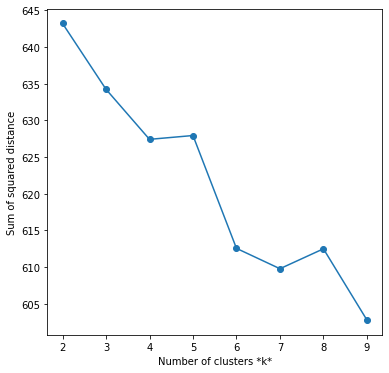

In [ ]:
plot_elbow(D)

[0.7918880558202508, 0.6598930952871577, 1.0290036387107504, 1.2713966617655905, 1.1754738347095237, 1.2548782494843735, 2.2584615033950595, 2.100307554644596]


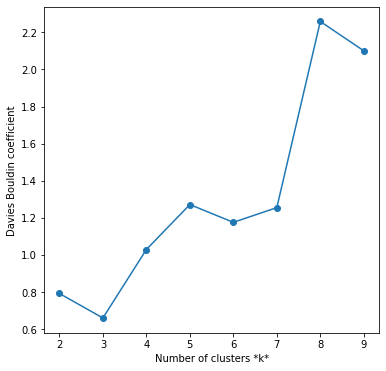

In [ ]:
plot_elbow(D_no_zeros, spherical=True)

In [ ]:
clusters = k_means(D, 2)

In [ ]:
clusters_spherical = spherical_k_means(D_no_zeros, 2)

In [ ]:
unique, counts = np.unique(clusters_spherical, return_counts=True)
for i in range(len(unique)):
  print(str(unique[i]) + ": " + str(counts[i]))

0: 500
1: 1


## Performing Silhouette Analysis

Inspiration: https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a

Therefore, we want the coefficients to be as big as possible and close to 1 to have a good clusters.

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


def silhouette_analysis(D, spherical=False):

  list_k = list(range(2, 10))

  for k in list_k:
    if not spherical:
      clusterer = KMeans(n_clusters=k, random_state=10)
      cluster_labels = clusterer.fit_predict(D)
    else:
      cluster_labels = spherical_k_means(D, k)
    silhouette_avg = silhouette_score(D, cluster_labels)
    print("For n_clusters = " + str(k) + " The average silhouette_score is :" + str(silhouette_avg))


    


In [ ]:
silhouette_analysis(D)

For n_clusters = 2 The average silhouette_score is :0.5794814162173964
For n_clusters = 3 The average silhouette_score is :0.3578298400068095
For n_clusters = 4 The average silhouette_score is :0.01683461416995387
For n_clusters = 5 The average silhouette_score is :0.026387867687630538
For n_clusters = 6 The average silhouette_score is :0.17931639822830306
For n_clusters = 7 The average silhouette_score is :-0.029999891251633524
For n_clusters = 8 The average silhouette_score is :-0.025961114172047987
For n_clusters = 9 The average silhouette_score is :0.033932072804295395


In [ ]:
silhouette_analysis(D_no_zeros)

For n_clusters = 2 The average silhouette_score is :0.5789859537779637
For n_clusters = 3 The average silhouette_score is :0.3571353329836654
For n_clusters = 4 The average silhouette_score is :0.016146217458407715
For n_clusters = 5 The average silhouette_score is :0.05663181764969273
For n_clusters = 6 The average silhouette_score is :0.09316409274794091
For n_clusters = 7 The average silhouette_score is :-0.11120321063929613
For n_clusters = 8 The average silhouette_score is :0.03551358167741828
For n_clusters = 9 The average silhouette_score is :0.0618959705227541


In [ ]:
def visualize_silhouette(D, spherical=False):
  list_k = list(range(2, 9))

  for k in list_k:

    fig = plt.figure(figsize=(8, 6))
    plt.xlim([-0.1, 1])
    plt.ylim([0, len(D) + (k + 1) * 10])

    if not spherical:
      clusterer = KMeans(n_clusters=k, random_state=10)
      cluster_labels = clusterer.fit_predict(D)

    else:
      cluster_labels = spherical_k_means(D, k)


    silhouette_avg = silhouette_score(D, cluster_labels)
    sample_silhouette_values = silhouette_samples(D, cluster_labels)

    y_lower = 10
    for i in range(k):
      ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
      ith_cluster_silhouette_values.sort()
      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / k)

      plt.fill_betweenx(
          np.arange(y_lower, y_upper),
          0,
          ith_cluster_silhouette_values,
          facecolor=color,
          edgecolor=color,
          alpha=0.7)

      plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for k = " + str(k))
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  plt.show()

    





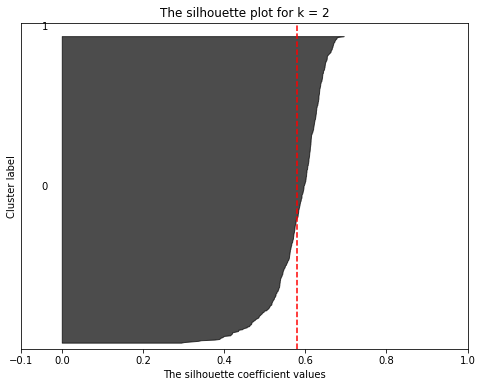

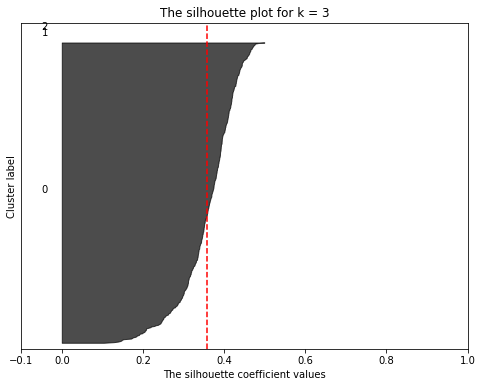

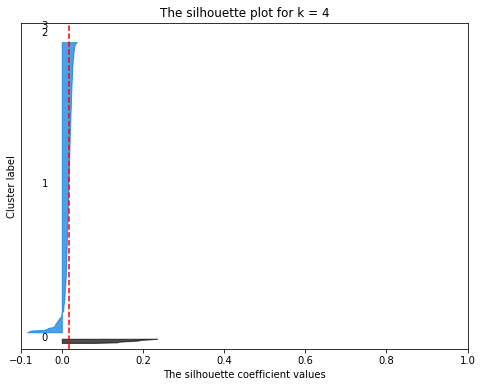

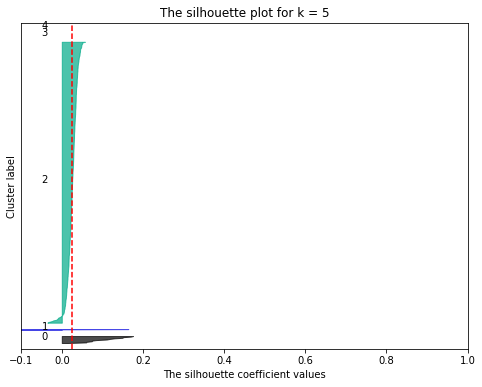

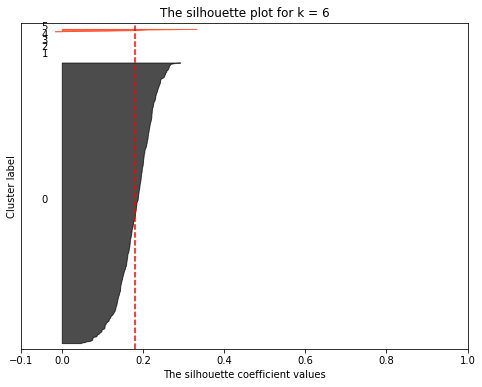

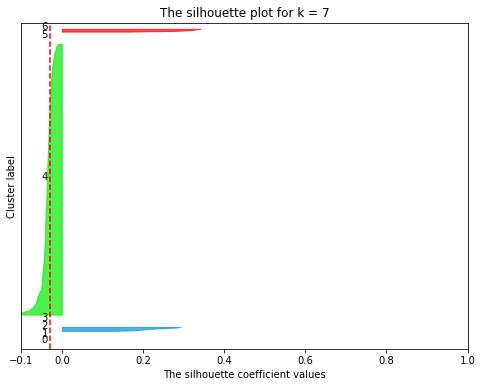

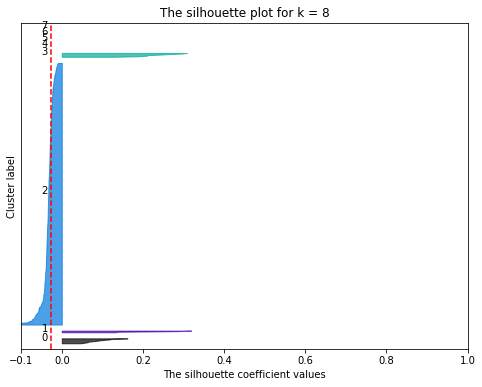

In [ ]:
visualize_silhouette(D)

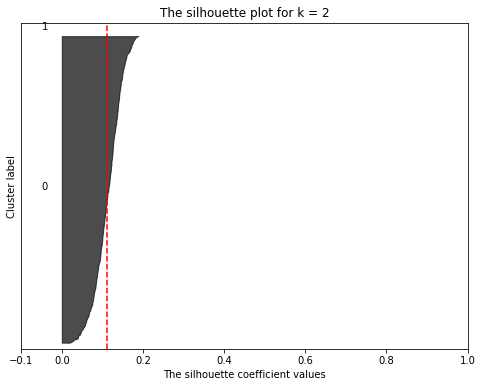

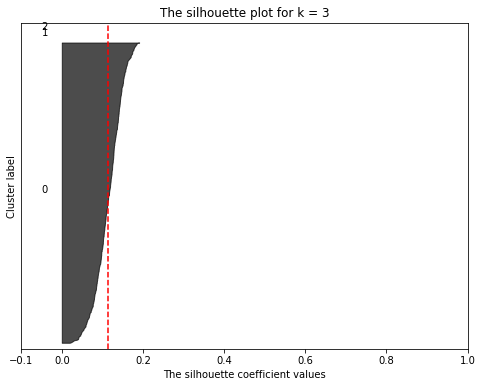

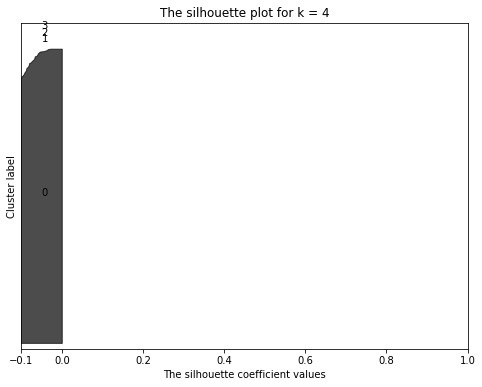

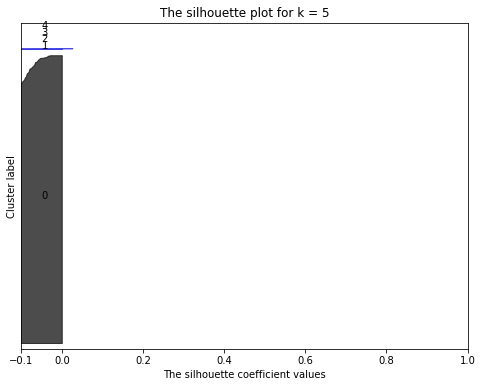

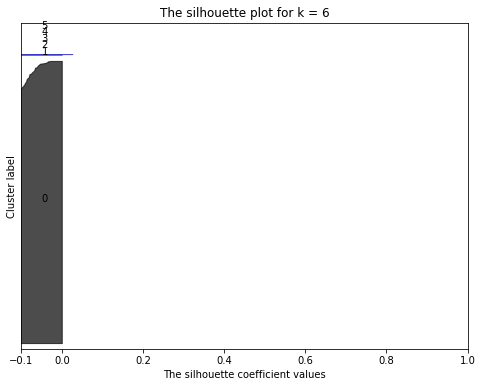

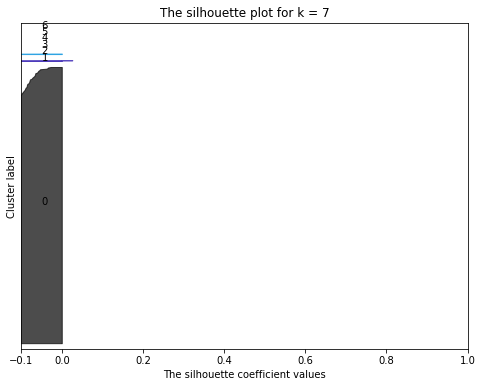

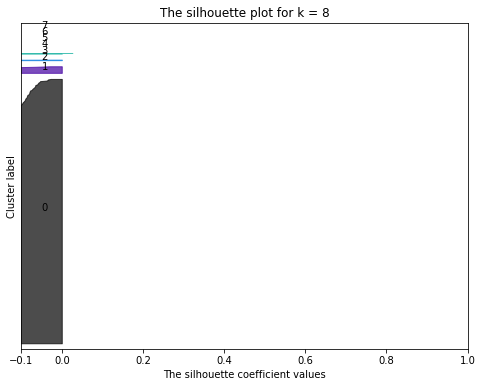

In [ ]:
visualize_silhouette(D_no_zeros, spherical = True)

## Apply PCA

In [ ]:
from sklearn.decomposition import PCA


def apply_pca(D):
  # initialize PCA with 2 components
  pca = PCA(n_components=2, random_state=42)
  # pass our X to the pca and store the reduced vectors into pca_vecs
  pca_vecs = pca.fit_transform(D)
  # save our two dimensions into x0 and x1
  x0 = pca_vecs[:, 0]
  x1 = pca_vecs[:, 1]

  return x0, x1

In [ ]:
x0, x1 = apply_pca(D)

In [ ]:
x0.shape

(502,)

In [ ]:
aldf['clusters'] = clusters
aldf['x0'] = x0
aldf['x1'] = x1

In [ ]:
articles = { 'title': titles_al, 'content': docs_al, 'cluster': clusters, 'x0': x0, 'x1': x1 }
frame = pd.DataFrame(articles, index = [clusters] , columns = ['title', 'content', 'cluster', 'x0', 'x1'])

In [ ]:
frame.head()

,title,content,cluster,x0,x1
1,"[court, convicts, video, arson]","[court, men, terror, slew, charges, involvemen...",1,-0.007125,-0.006710
1,"[new, rules, foreigners, stir, outrage]","[legal, experts, academics, digital, outrage, ...",1,-0.006227,-0.002449
1,"[raid, jenin, camp]","[dead, teenager, raid, jenin, area, northern]",1,-0.013005,-0.005420
1,[raid],"[raid, aqabet, jaber, refugee, camp, jericho, ...",1,-0.010277,-0.003512
1,"[role, mediator]","[tensions, past, weeks]",1,-0.007535,-0.002856


In [ ]:
frame['cluster'].value_counts() 

1    501
0      1
Name: cluster, dtype: int64

In [ ]:
grouped = frame['title'].groupby(frame['cluster'])

In [ ]:
def get_top_keywords(D, clusters, n):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(D).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([total_vocab[t] for t in np.argsort(r)[-n:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            


In [ ]:
get_top_keywords(D, clusters, 10)


Cluster 0
rule,participate,flags,quarter,warnings,year,time,refugees,unrwa,race

Cluster 1
troops,boy,prisoner,family,mosque,protest,attacks,death,sheikh,attack


In [ ]:
get_top_keywords(D_no_zeros, clusters_spherical, 10)


Cluster 0
troops,boy,prisoner,family,mosque,protest,attacks,death,sheikh,attack

Cluster 1
choi,juyoung,swimming,nothing,avoid,coast,sea,waters,sewage,raw


In [ ]:
import seaborn as sns

def plot_2d(df, spherical = False):
  # set image size
  plt.figure(figsize=(12, 7))
  # set a title
  plt.title("TF-IDF + KMeans", fontdict={"fontsize": 18})
  # set axes names
  plt.xlabel("X0", fontdict={"fontsize": 16})
  plt.ylabel("X1", fontdict={"fontsize": 16})
  # create scatter plot with seaborn, where hue is the class used to group the data
  sns.scatterplot(data=df, x='x0', y='x1', hue='clusters', palette="viridis")
  plt.show()

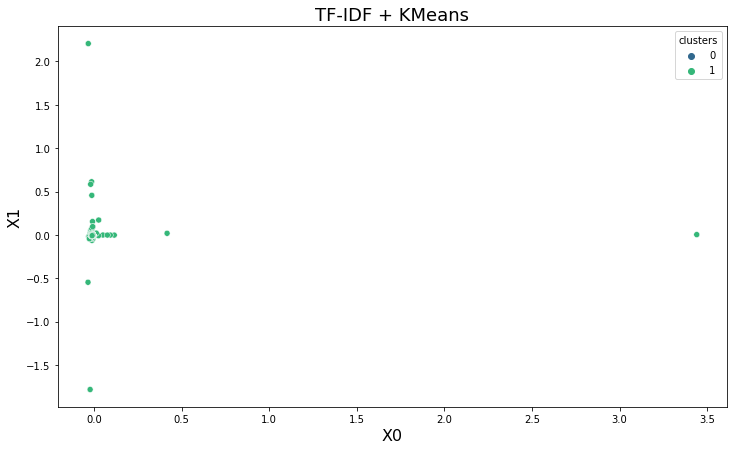

In [ ]:
plot_2d(aldf)

In [ ]:
x0_s, x1_s = apply_pca(D_no_zeros)

In [ ]:
new_frame_cols = {'x0': x0_s, 'x1': x1_s, 'clusters': clusters_spherical }
frame = pd.DataFrame(new_frame_cols, columns = ['x0', 'x1', 'clusters'])

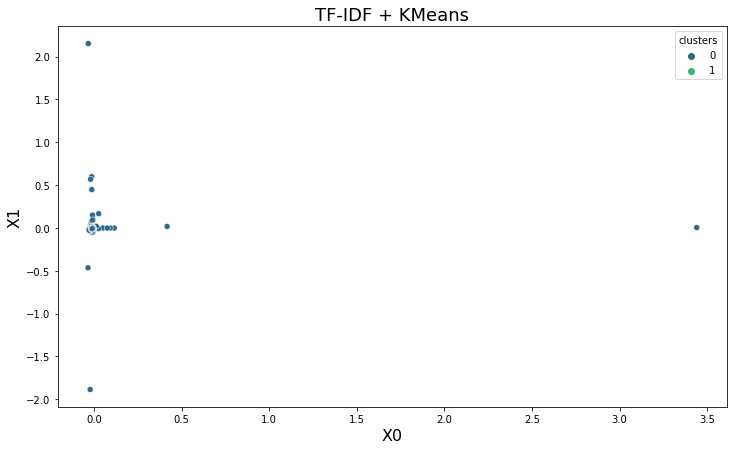

In [ ]:
plot_2d(frame)

# CNN 

In [ ]:
filename = 'drive/My Drive/SML310/cnn50all.csv'
cnndf = pd.read_csv(filename)

In [ ]:
for i in range(len(cnndf['u-time'])):
  cnndf['u-time'][i] = re.sub("^(.+?),", '', str(cnndf['u-time'][i]))

In [ ]:
cnndf.head()

,title,u-time,content
0,"April 19, 2022 Russia-Ukraine news",nan,NaN
1,Amnesty accuses Israel of apartheid over treat...,"Wed February 2, 2022",Jerusalem (CNN)Amnesty International has becom...
2,What one meeting in Israel says about a changi...,nan,"Jerusalem (CNN)There have been a lot of ""first..."
3,"UK anti-Semitism reaches record high in 2021, ...","Wed February 9, 2022",London (CNN)More incidents of anti-Semitism
4,How to start the Mediterranean diet — meal by ...,"Tue December 28, 2021","Sign up for CNN's Eat, But Better: Mediterrane..."


In [ ]:
cnndf.dropna(subset=['title', 'content'], inplace=True)
cnndf.reset_index(drop=True, inplace=True)

In [ ]:
cnndf.head()

,title,u-time,content
0,Amnesty accuses Israel of apartheid over treat...,"Wed February 2, 2022",Jerusalem (CNN)Amnesty International has becom...
1,What one meeting in Israel says about a changi...,nan,"Jerusalem (CNN)There have been a lot of ""first..."
2,"UK anti-Semitism reaches record high in 2021, ...","Wed February 9, 2022",London (CNN)More incidents of anti-Semitism
3,How to start the Mediterranean diet — meal by ...,"Tue December 28, 2021","Sign up for CNN's Eat, But Better: Mediterrane..."
4,"As South Africa mourns Desmond Tutu, so do LGB...","Mon December 27, 2021","(CNN)On Monday, cathedral bells tolled at mid..."


In [ ]:
# Remove everything before first comma

# for i in range(len(cnndf['content'])):
#   cnndf['content'][i] = re.sub("^[^,]*,", "", str(cnndf['content'][i]))

In [ ]:
# Remove everything before first closing bracket

for i in range(len(df['content'])):
  df['content'][i] = df['content'][i].split(')')[-1]



In [ ]:
len(cnndf)

415

In [ ]:
docs_cnn = cnndf['content'].copy(deep=True)
titles_cnn = cnndf['title'].copy(deep=True)

In [ ]:
docs_cnn = tokenize(docs_cnn)
docs_cnn = remove_stop(docs_cnn)
docs_cnn = remove_N_common(docs_cnn, 30)
docs_cnn = keep_pos(docs_cnn)

In [ ]:
titles_cnn = tokenize(titles_cnn)
titles_cnn = remove_stop(titles_cnn)
titles_cnn = remove_N_common(titles_cnn, 15)
titles_cnn = keep_pos(titles_cnn)

In [ ]:
DF_cnn = DF_count(docs_cnn, titles_cnn)


In [ ]:
tfidf_docs_cnn = tf_idf(docs_cnn, titles_cnn, DF_cnn)
tfidf_titles_cnn = tf_idf(titles_cnn, docs_cnn, DF_cnn)

In [ ]:
alpha = 0.3

for i in tfidf_docs_cnn:
    tfidf_docs_cnn[i] *= alpha

for i in tfidf_titles_cnn:
    tfidf_docs_cnn[i] = tfidf_titles_cnn[i]


In [ ]:
total_vocab_N = len(DF_cnn)
N = len(docs_cnn)
total_vocab = [x for x in DF_cnn]

In [ ]:
D_cnn = np.zeros((N, total_vocab_N))

for i in tfidf_docs_cnn:
  try:
      ind = total_vocab.index(i[1])
      D_cnn[i[0]][ind] = tfidf_docs_cnn[i]
  except:
      pass

In [ ]:
D_cnn.shape

(415, 3304)

[311.03489405855976, 309.8774900020072, 305.43373499299605, 304.4733107749279, 305.0008300276205, 300.57471322163394, 289.36621378064274, 287.0235897473907]


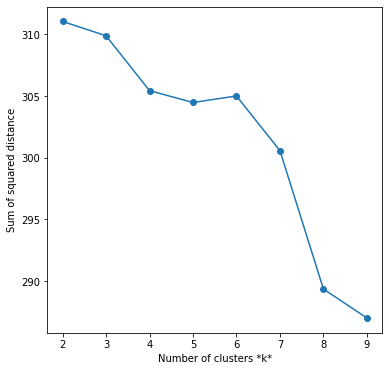

In [ ]:
plot_elbow(D_cnn)

In [ ]:
silhouette_analysis(D_cnn)

For n_clusters = 2 The average silhouette_score is :0.21247360217999023
For n_clusters = 3 The average silhouette_score is :0.21300620264515177
For n_clusters = 4 The average silhouette_score is :0.28625539738458994
For n_clusters = 5 The average silhouette_score is :0.14070138139965888
For n_clusters = 6 The average silhouette_score is :0.1246365427889268
For n_clusters = 7 The average silhouette_score is :-0.030190597346300703
For n_clusters = 8 The average silhouette_score is :0.23730481318093827
For n_clusters = 9 The average silhouette_score is :-0.053633703645086815


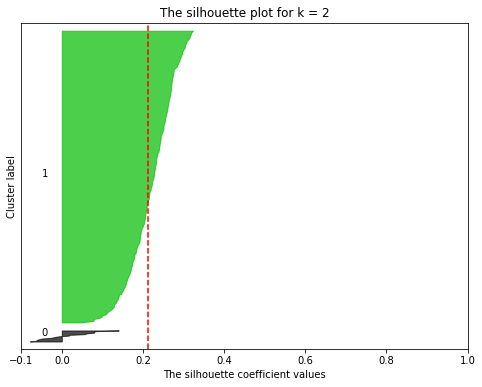

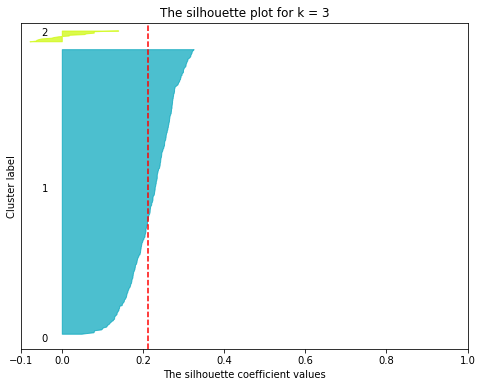

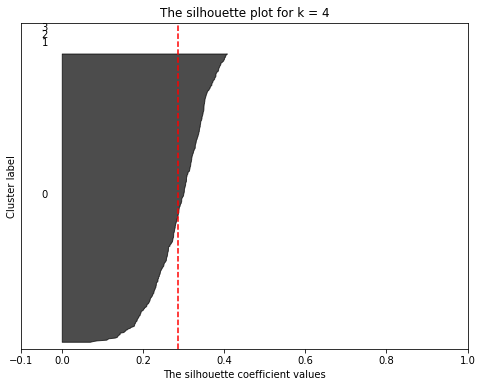

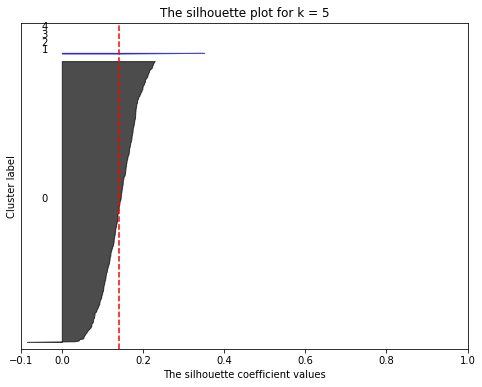

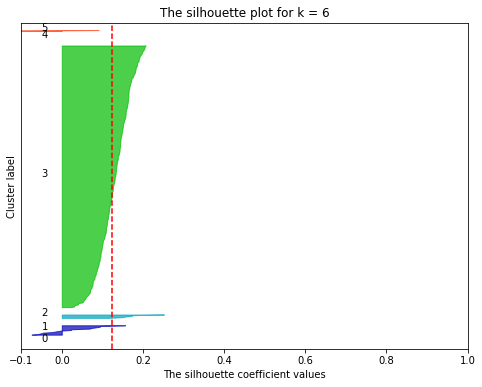

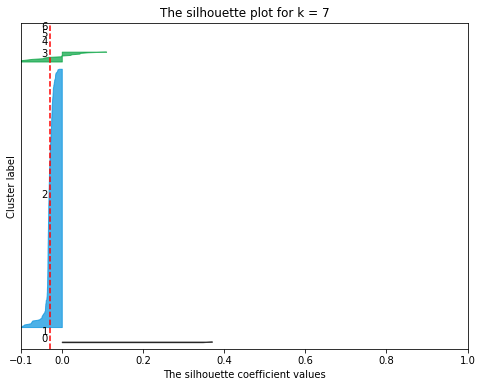

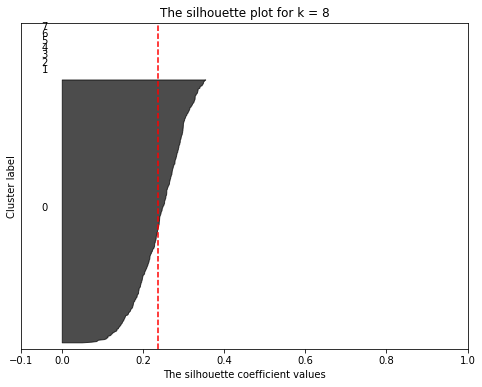

In [ ]:
visualize_silhouette(D_cnn)

In [ ]:
clusters_cnn_2 = k_means(D_cnn, 2)
clusters_cnn_5 = k_means(D_cnn, 5)

In [ ]:
get_top_keywords(D_cnn, clusters_cnn_2, 10)


Cluster 0
isis,world,deal,sanders,obama,decision,plan,carter,fast,facts

Cluster 1
pianist,stay,quiet,observers,shut,airplane,start,diet,mediterranean,meal


In [ ]:
get_top_keywords(D_cnn, clusters_cnn_5, 10)


Cluster 0
pianist,stay,quiet,observers,wuhayshi,burn,airplane,page,show,transcript

Cluster 1
plans,plan,part,light,green,looks,west,bank,parts,annex

Cluster 2
isis,world,plan,deal,sanders,obama,decision,carter,fast,facts

Cluster 3
pianist,stay,quiet,observers,shut,airplane,start,diet,mediterranean,meal

Cluster 4
pianist,stay,quiet,observers,wuhayshi,significant,fast,facts,arab,league


## Using PCA to visualize

In [ ]:
x0, x1 = apply_pca(D_cnn)

In [ ]:
cnndf['clusters'] = clusters_cnn_4
cnndf['x0'] = x0
cnndf['x1'] = x1

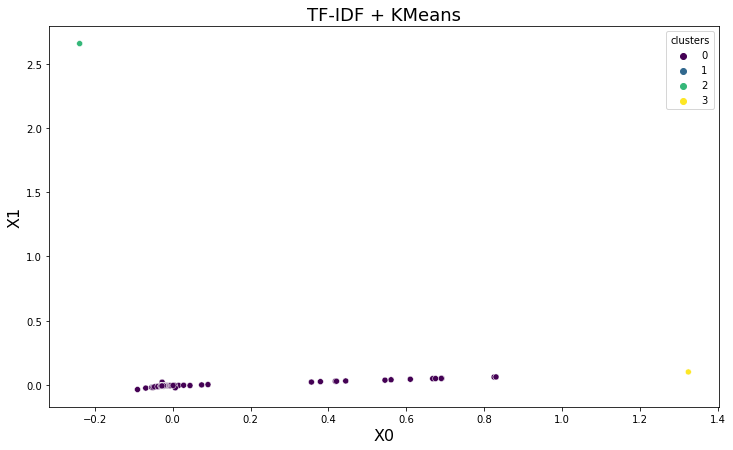

In [ ]:
plot_2d(cnndf)

In [ ]:
## SPHERICAL STUFF

D_cnn_no = D_cnn[~np.all(D_cnn == 0, axis=1)]


[0.29895420266704315, 0.6584027011136424, 1.3302580693995811, 1.4339267968424756, 1.8735264769496356, 1.896588893965976, 2.6971347741598444, 2.7589443484490435]


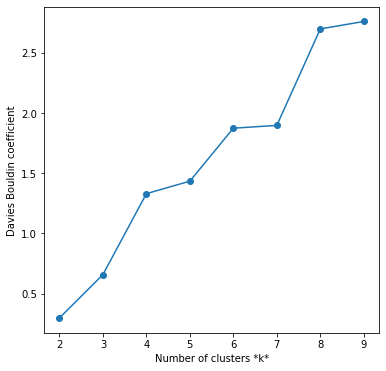

In [ ]:
plot_elbow(D_cnn_no, spherical=True)

In [ ]:
clusters_spherical_cnn_2 = spherical_k_means(D_cnn_no, 2)
clusters_spherical_cnn_4 = spherical_k_means(D_cnn_no, 4)

In [ ]:
silhouette_analysis(D_cnn_no)

For n_clusters = 2 The average silhouette_score is :0.21247360217999023
For n_clusters = 3 The average silhouette_score is :0.21300620264515177
For n_clusters = 4 The average silhouette_score is :0.28625539738458994
For n_clusters = 5 The average silhouette_score is :0.14070138139965888
For n_clusters = 6 The average silhouette_score is :0.1246365427889268
For n_clusters = 7 The average silhouette_score is :-0.030190597346300703
For n_clusters = 8 The average silhouette_score is :0.23730481318093827
For n_clusters = 9 The average silhouette_score is :-0.053633703645086815


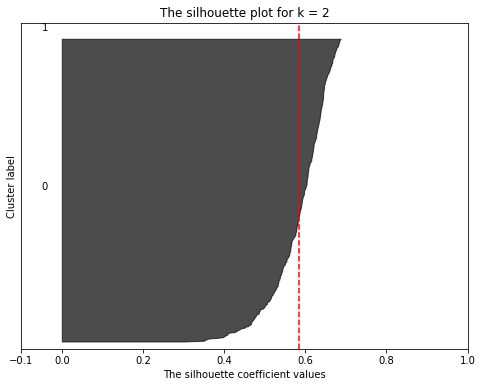

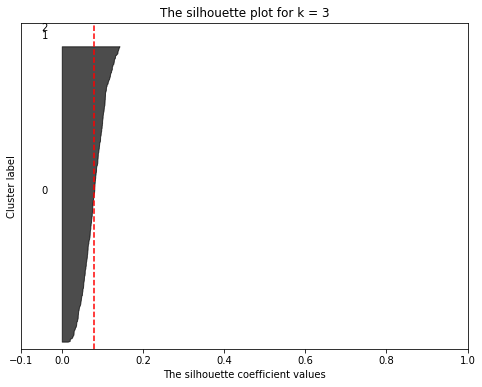

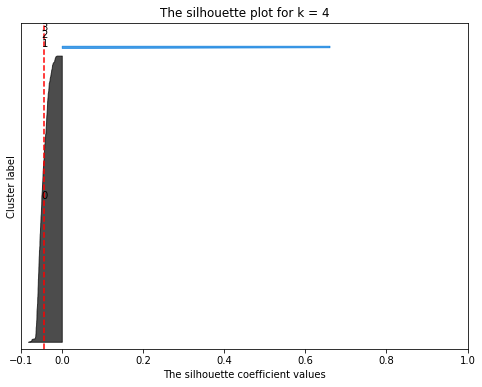

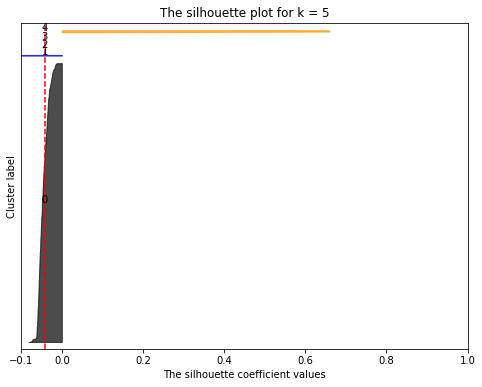

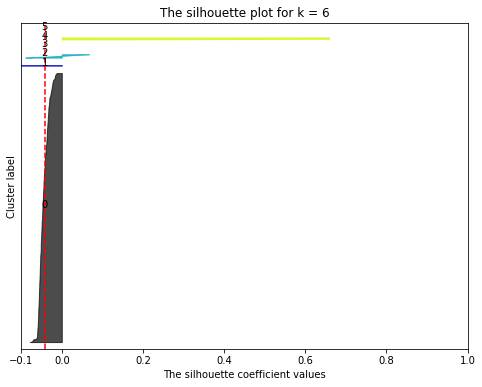

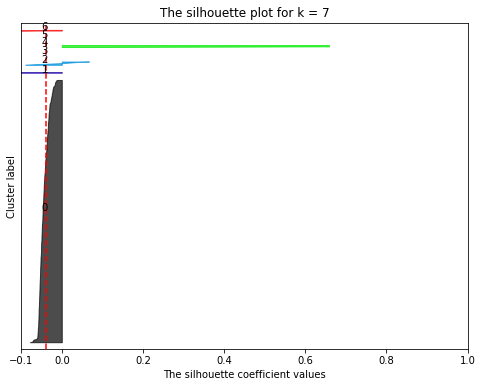

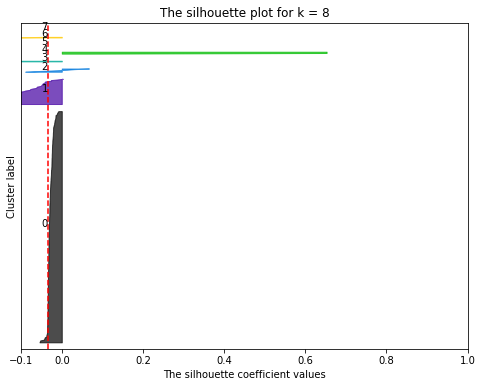

In [ ]:
visualize_silhouette(D_cnn_no, spherical = True)

In [ ]:
get_top_keywords(D_cnn_no, clusters_spherical_cnn_2, 10)


Cluster 0
isis,world,deal,sanders,obama,decision,plan,carter,fast,facts

Cluster 1
pianist,stay,quiet,observers,shut,airplane,start,diet,mediterranean,meal


In [ ]:
get_top_keywords(D_cnn_no, clusters_spherical_cnn_4, 10)


Cluster 0
isis,world,deal,sanders,obama,decision,plan,carter,fast,facts

Cluster 1
sport,surprises,shock,nfl,fa,weekend,cup,page,show,transcript

Cluster 2
attempts,hide,monitor,bond,bars,stays,bishop,flds,lyle,jeffs

Cluster 3
pianist,stay,quiet,observers,shut,airplane,start,diet,mediterranean,meal


# Sentiment Analysis

Inspiration: https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

def get_polarity(df):
  for title in df['title']:
    pol_score = sia.polarity_scores(title)
    pol_score['headline'] = title
    results.append(pol_score)
  return results



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
results = get_polarity(aldf)
print(results[:3])

[{'neg': 0.0, 'neu': 0.684, 'pos': 0.316, 'compound': 0.5719, 'headline': 'Israel court convicts seven over wedding video celebrating arson'}, {'neg': 0.268, 'neu': 0.732, 'pos': 0.0, 'compound': -0.5106, 'headline': 'New Israeli rules on foreigners visiting West Bank stir outrage'}, {'neg': 0.391, 'neu': 0.609, 'pos': 0.0, 'compound': -0.6705, 'headline': 'Palestinian killed during Israeli raid on Jenin camp'}]


In [ ]:
df_1 = pd.DataFrame.from_records(results)
df_1.head()

,neg,neu,pos,compound,headline
0,0.000,0.684,0.316,0.5719,Israel court convicts seven over wedding video...
1,0.268,0.732,0.000,-0.5106,New Israeli rules on foreigners visiting West ...
2,0.391,0.609,0.000,-0.6705,Palestinian killed during Israeli raid on Jeni...
3,0.370,0.630,0.000,-0.6908,Israeli forces kill Palestinian in occupied We...
4,0.000,1.000,0.000,0.0000,Egypt’s role in Gaza: More than a mediator


In [ ]:
def add_labels(df):
  df['label'] = 0
  df.loc[df['compound'] > 0.2, 'label'] = 1
  df.loc[df['compound'] < -0.2, 'label'] = -1
  return df


In [ ]:
df_1 = add_labels(df_1)
print(df_1.label.value_counts(normalize=True) * 100)


-1    54.98008
 0    36.25498
 1     8.76494
Name: label, dtype: float64


In [ ]:
def plot_polarity(df):
  fig, ax = plt.subplots(figsize=(8, 8))

  counts = df.label.value_counts(normalize=True) * 100

  sns.barplot(x=counts.index, y=counts, ax=ax)

  ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
  ax.set_ylabel("Percentage")

  plt.show()

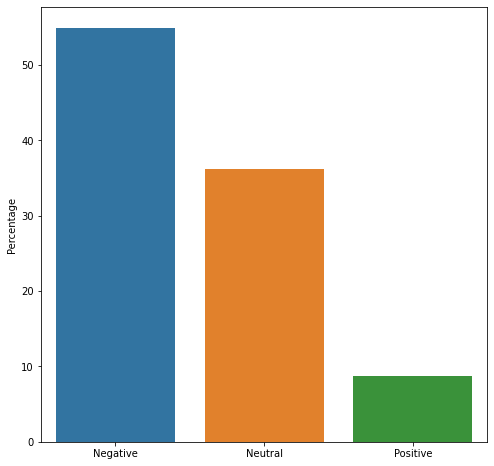

In [ ]:
plot_polarity(df_1)

In [ ]:
## SENTIMENT ANALYSIS CNN

results = get_polarity(cnndf)
df_2 = pd.DataFrame.from_records(results)
df_2.head()

,neg,neu,pos,compound,headline
0,0.000,0.684,0.316,0.5719,Israel court convicts seven over wedding video...
1,0.268,0.732,0.000,-0.5106,New Israeli rules on foreigners visiting West ...
2,0.391,0.609,0.000,-0.6705,Palestinian killed during Israeli raid on Jeni...
3,0.370,0.630,0.000,-0.6908,Israeli forces kill Palestinian in occupied We...
4,0.000,1.000,0.000,0.0000,Egypt’s role in Gaza: More than a mediator


In [ ]:
df_2 = add_labels(df_2)
print(df_2.label.value_counts(normalize=True) * 100)

-1    46.782988
 0    40.348964
 1    12.868048
Name: label, dtype: float64


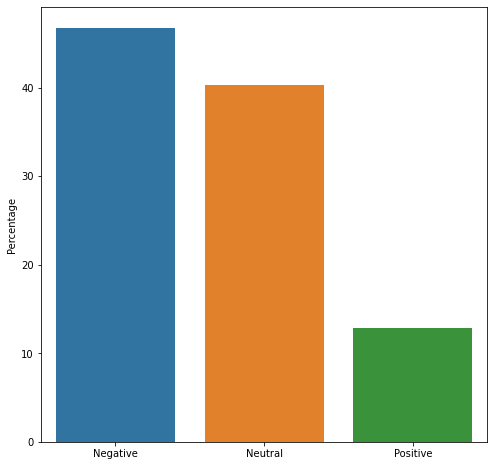

In [ ]:
plot_polarity(df_2)